In [68]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import itertools
from scipy.stats import wilcoxon, shapiro, ttest_rel

import pickle
import os

from datetime import date
print(date.today())


2025-12-08


In [ ]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'

output_path = f'{workdir}/result/dataset_pmuscle_36'
datasetdir = f'{workdir}/pmuscle_36_processed' 
use = 'pmuscle36' # 13k gene min 10 reads
tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
phase =''
outlier_sample_col = 'Sample'
outlier_gene_col = 'Gene' 

samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

tissues.head()

/mnt/disk7t/xwj/axolotl_rev//result/dataset_pmuscle_36/samples


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,M,muscle,36,13573,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...


In [42]:
from sklearn.metrics import auc
# 遇到的问题 general.pred_outlier_auprc(df_pred, df_outlier)时NameError: name 'auc' is not defined
# 改成直接重定义
def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]

## 定义函数来计算AUPRC
def pred_outlier_auprc(res_data, df_outlier):
    
    res_data.index.name = 'Gene'
    res_data.columns.name = 'Sample'
    res_data = res_data.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    sorted_data = res_data.sort_values(by='pred',ascending=True)
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)
    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1,num=n_seg+1)

In [46]:
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust']

baselines = [ 'ABEILLE','OUTRIDER', 'OUTSINGLE',]
mymethods = ['f0.1L20']
methods = baselines + mymethods

num = 49
print(num, phase, methods)

49  ['ABEILLE', 'OUTRIDER', 'OUTSINGLE', 'f0.1L20']


In [ ]:


gene_sizes = [ 12000 ]
n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # positive samples
    outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
    assert outlier['Sample'].size == len(set(outlier['Sample']))
    output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
    
    sampled_configs = pickle.load(open(output_file, 'rb'))
    outliers_used = outlier.copy()
    
    for size in gene_sizes:
        print(size)

        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        for seed in range(n_replicates):
            k = seed
            dict_res[k] = dict() # 10 seeds 
            dict_auprc[k] = dict()
            dict_curve[k] = dict()
            # 获取当前抽样的配置
            current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
            task_config = current_config['config']
            samples_used = current_config['selected_samples']
            df_outlier = outliers_used.query('(Sample in @samples_used)').copy()
            
            for m in methods:
                # ==> level 3. (tissue, task, method)
                print(size, seed, m)
                dict_res[k][m]= dict()
                for j,row in task_config.iterrows():                    
                    #----------- 调用函数auprc
                    # print(df_outlier.head())
                    
                    if m == 'ABEILLE':
                        
                        df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                        df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                        class_col = 'predict'
                        
                        for score in abl_scores:
                            dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                            dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
        
                    elif m == 'OUTRIDER':
                        
                        df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                        df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                        class_col = 'aberrant'

                        for score in outrider_scores: # score = 'pValue'
                            dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                            dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                    
                    elif m == 'OUTSINGLE':
                        
                        df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                        dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                        dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)
                        
                    else:
                        df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                        dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                        dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)                    
        
        file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
        outputdata = [ t, tn, i, dict_auprc, dict_curve ]
        import pickle
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )


t00_M_s36_g13573


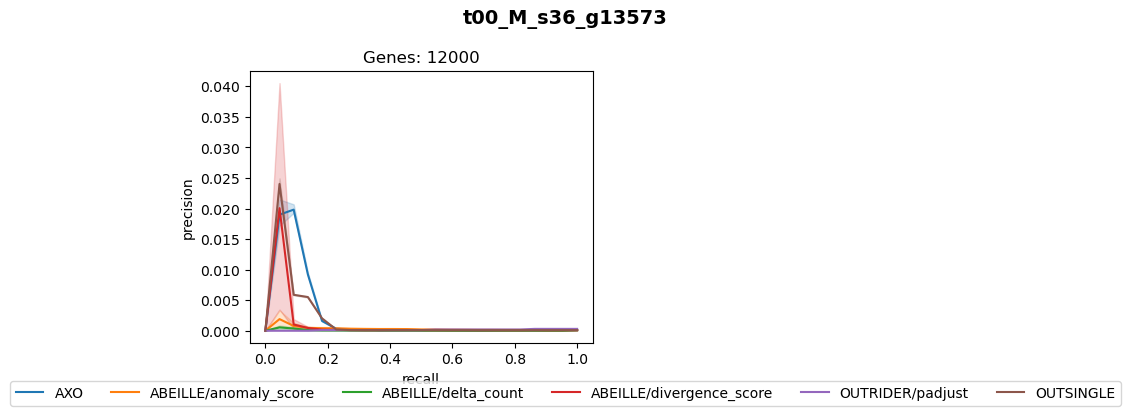

In [52]:
draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
auprc_data_for_boxplot = dict()
# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    print(name_prefix)

    plt.style.use('default')

    fig, axes = plt.subplots(1, len(gene_sizes)+1, figsize=(8*len(gene_sizes), 4), sharey=True )
    myindex = pd.MultiIndex.from_tuples([ (size, k) for size in gene_sizes for k in range(n_replicates) ],names=['size', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)

    for i, size in enumerate(gene_sizes):
        
        # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
        file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
        
        for k in range(n_replicates):
            auprc.loc[(size, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]
            
        required_sets = 1
        draw = \
        pd.concat([
        pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                    axis=0, keys= range(required_sets)).drop_duplicates(subset=['label', 'precision', 'recall']).reset_index(drop=True)
            for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
        for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).rename(index={ 'f0.1L20':'AXO'})
            
        sns.lineplot(
            data=draw,
            x="recall",
            y="precision",
            hue="method",
            palette='tab10',
            ax=axes[i],
            errorbar=('ci', 95),  # 90%置信区间
            n_boot=100,  # bootstrap采样次数
            alpha=1,
        )
        axes[i].set_title(f'Genes: {size}')
            # 1. 去掉子图自己的图例
        axes[i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0.02),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    # fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')    
    auprc_data_for_boxplot[name_prefix] = auprc
    
    axes[1].set_visible(False)
    fig.subplots_adjust(bottom=0.2)
    fig.suptitle(name_prefix, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{workdir}/result/figure/pmuscle_prcurve_sizes13k_gene12k.pdf',dpi=200, bbox_inches='tight')


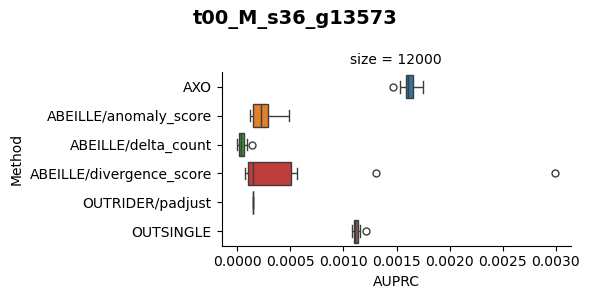

In [71]:
for name_prefix, auprc in auprc_data_for_boxplot.items():
    auprc_long = auprc.rename(columns={'f0.1L20':'AXO'}).stack().reset_index(name='AUPRC').rename(columns={'level_2':'Method'})
    
    g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='size', 
                orient='h', palette='tab10', sharex=False, height=3, aspect=2)
    g.fig.suptitle(name_prefix, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{workdir}/result/figure/pmuscle_box_auprc_sizes13k_gene12k.pdf', dpi=200)
    
    # p-value
    auprc_all_sizes = auprc.astype(np.float32).copy()
    

In [59]:
size

12000

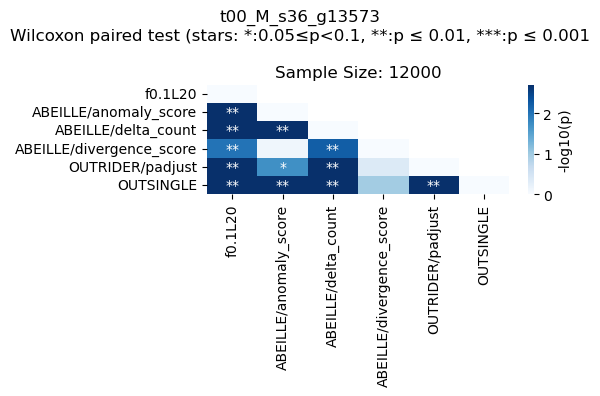

In [70]:
plt.style.use('default')

fig, axes = plt.subplots(1, 1, figsize=(6*1, 4), sharey=True, sharex=True)

auprc = auprc_all_sizes.query('size == @size').droplevel('size')
columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

axo_results = results#.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
# ---- 1. 对称矩阵化 ----
pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
pivot = pivot.combine_first(pivot.T)        # 补全下三角
np.fill_diagonal(pivot.values, 1)           # 对角=1

pivot = pivot.loc[columns, columns] # use the meothds order in auprc
# ---- 2. -log10 变换 ----
log_p = -np.log10(pivot)
log_p = log_p.replace([np.inf, -np.inf], np.nan)

# ---- 3. 三角掩码 ----
mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

def p2star(p):
    if pd.isna(p) or p > 0.05:
        return ''
    elif p <= 1e-4:
        return '****'
    elif p <= 1e-3:
        return '***'
    elif p <= 1e-2:
        return '**'
    else:
        return '*'

# 1. 星号对称矩阵（同索引）
star_mat = pivot.applymap(p2star)

# ---- 4. 画图 ----
# plt.figure(figsize=(10, 5))
sns.heatmap(log_p,
            mask=mask,
            cmap='Blues',
            annot=star_mat,
            fmt='',
            cbar_kws={'label': '-log10(p)'}, ax=axes)
# axes[sample_sizes.index(size)].set_xticklabels(axes[sample_sizes.index(size)].get_xticklabels(), rotation=90)
axes.set_title(f'Sample Size: {size}')

plt.suptitle(f'{name_prefix}\nWilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/pmuscle_heatmap_auprc_wilcox_p_star.pdf',dpi=200)